In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
img = cv2.imread('test_images/solidWhiteCurve.jpeg')

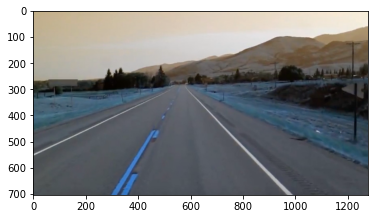

In [38]:
plt.imshow(img)

In [39]:
def color_filter(image):
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    lower = np.array([0,190,0])
    upper = np.array([255,255,255])
    yellower = np.array([10,0,90])
    yelupper = np.array([50,255,255])
    yellowmask = cv2.inRange(hls, yellower, yelupper)    
    whitemask = cv2.inRange(hls, lower, upper)
    mask = cv2.bitwise_or(yellowmask, whitemask)  
    masked = cv2.bitwise_and(image, image, mask = mask)    
    return masked

In [40]:
fimg = color_filter(img)

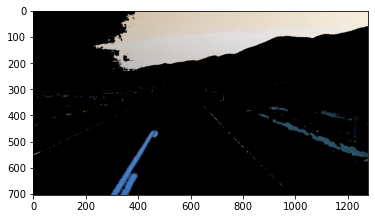

In [41]:
plt.imshow(fimg)

In [42]:
def roi(img):
    x = int(img.shape[1])
    y = int(img.shape[0])
    shape = np.array([[int(0), int(y)], [int(x), int(y)], [int(0.55*x), int(0.6*y)], [int(0.45*x), int(0.6*y)]])
    mask = np.zeros_like(img)
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    cv2.fillPoly(mask, np.int32([shape]), ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [43]:
mimg = roi(fimg)

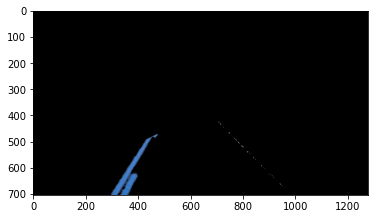

In [44]:
plt.imshow(mimg)

In [45]:
def canny(img):
    gimg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return cv2.Canny(gimg, 50, 120)

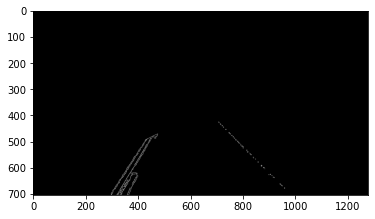

In [46]:
cimg = canny(mimg)
plt.imshow(cimg,cmap='gray')

In [47]:
rightSlope, leftSlope, rightIntercept, leftIntercept = [],[],[],[]
def draw_lines(img, lines, thickness=5):
    global rightSlope, leftSlope, rightIntercept, leftIntercept
    rightColor=[0,255,0]
    leftColor=[255,0,0]
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y1-y2)/(x1-x2)
            if slope > 0.3:
                if x1 > 500 :
                    yintercept = y2 - (slope*x2)                    
                    rightSlope.append(slope)
                    rightIntercept.append(yintercept)
                else: None                
            elif slope < -0.3:
                if x1 < 600:
                    yintercept = y2 - (slope*x2)                    
                    leftSlope.append(slope)
                    leftIntercept.append(yintercept)    
    leftavgSlope = np.mean(leftSlope[-30:])
    leftavgIntercept = np.mean(leftIntercept[-30:])
    
    rightavgSlope = np.mean(rightSlope[-30:])
    rightavgIntercept = np.mean(rightIntercept[-30:])
    try:
        left_line_x1 = int((0.65*img.shape[0] - leftavgIntercept)/leftavgSlope)
        left_line_x2 = int((img.shape[0] - leftavgIntercept)/leftavgSlope)
    
        right_line_x1 = int((0.65*img.shape[0] - rightavgIntercept)/rightavgSlope)
        right_line_x2 = int((img.shape[0] - rightavgIntercept)/rightavgSlope)

        pts = np.array([[left_line_x1, int(0.65*img.shape[0])],[left_line_x2, int(img.shape[0])],[right_line_x2, int(img.shape[0])],[right_line_x1, int(0.65*img.shape[0])]], np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.fillPoly(img,[pts],(0,0,255))      
        
        
        cv2.line(img, (left_line_x1, int(0.65*img.shape[0])), (left_line_x2, int(img.shape[0])), leftColor, 10)
        cv2.line(img, (right_line_x1, int(0.65*img.shape[0])), (right_line_x2, int(img.shape[0])), rightColor, 10)
    except ValueError:
        pass
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def linedetect(img):
    return hough_lines(img, 1, np.pi/180, 10, 20, 100)

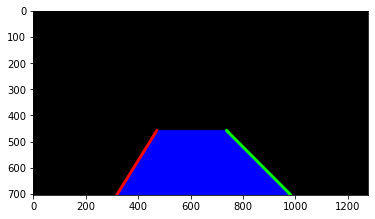

In [48]:
himg = linedetect(cimg)
plt.imshow(himg)

In [49]:
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

def weightSum(input_set):
    img = list(input_set)
    return cv2.addWeighted(img[0], 1, img[1], 0.8, 0)

In [50]:
rimg = weightSum((himg, img))

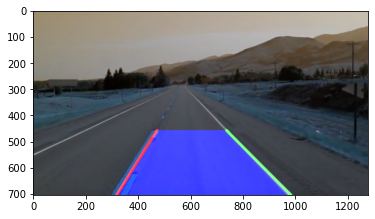

In [51]:
plt.imshow(rimg)

In [54]:
cap = cv2.VideoCapture('test_videos/solidWhiteRight.mp4')
if cap.isOpened() == False:
    print('ERROR : File not found or wrong codec used')
    
while cap.isOpened():
    ret, frame = cap.read()
    if ret == True:
        rframe = simple_lane(frame)
        cv2.imshow('frame',rframe)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    else:
        break
        
cap.release()
cv2.destroyAllWindows()

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

rightSlope, leftSlope, rightIntercept, leftIntercept = [],[],[],[]
def draw_lines(img, lines, thickness=5):
    global rightSlope, leftSlope, rightIntercept, leftIntercept
    rightColor=[0,255,0]
    leftColor=[255,0,0]
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y1-y2)/(x1-x2)
            if slope > 0.3:
                if x1 > 500 :
                    yintercept = y2 - (slope*x2)                    
                    rightSlope.append(slope)
                    rightIntercept.append(yintercept)
                else: None                
            elif slope < -0.3:
                if x1 < 600:
                    yintercept = y2 - (slope*x2)                    
                    leftSlope.append(slope)
                    leftIntercept.append(yintercept)    
    leftavgSlope = np.mean(leftSlope[-30:])
    leftavgIntercept = np.mean(leftIntercept[-30:])
    
    rightavgSlope = np.mean(rightSlope[-30:])
    rightavgIntercept = np.mean(rightIntercept[-30:])
    try:
        left_line_x1 = int((0.65*img.shape[0] - leftavgIntercept)/leftavgSlope)
        left_line_x2 = int((img.shape[0] - leftavgIntercept)/leftavgSlope)
    
        right_line_x1 = int((0.65*img.shape[0] - rightavgIntercept)/rightavgSlope)
        right_line_x2 = int((img.shape[0] - rightavgIntercept)/rightavgSlope)

        pts = np.array([[left_line_x1, int(0.65*img.shape[0])],[left_line_x2, int(img.shape[0])],[right_line_x2, int(img.shape[0])],[right_line_x1, int(0.65*img.shape[0])]], np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.fillPoly(img,[pts],(0,0,255))      
        
        
        cv2.line(img, (left_line_x1, int(0.65*img.shape[0])), (left_line_x2, int(img.shape[0])), leftColor, 10)
        cv2.line(img, (right_line_x1, int(0.65*img.shape[0])), (right_line_x2, int(img.shape[0])), rightColor, 10)
    except ValueError:
        pass
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def simple_lane(image):
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    lower = np.array([0,190,0])
    upper = np.array([255,255,255])
    ylower = np.array([10,0,90])
    yupper = np.array([50,255,255])
    ymask = cv2.inRange(hls, ylower, yupper)    
    wmask = cv2.inRange(hls, lower, upper)
    mask1 = cv2.bitwise_or(ymask, wmask)  
    fil_img = cv2.bitwise_and(image, image, mask = mask1) 
    
    x = int(fil_img.shape[1])
    y = int(fil_img.shape[0])
    shape = np.array([[int(0), int(y)], [int(x), int(y)], [int(0.55*x), int(0.6*y)], [int(0.45*x), int(0.6*y)]])
    mask2 = np.zeros_like(fil_img)
    if len(fil_img.shape) > 2:
        ch_count = fil_img.shape[2]
        ig_mcolor = (255,) * ch_count
    else:
        ig_mcolor = 255
    cv2.fillPoly(mask2, np.int32([shape]), ig_mcolor)
    masked_img = cv2.bitwise_and(fil_img, mask2)
    canny_img = cv2.Canny((cv2.cvtColor(masked_img, cv2.COLOR_RGB2GRAY)),50,120)
    hough_img = hough_lines(canny_img, 1, np.pi/180, 10, 20, 100)
    fin_img = cv2.addWeighted(hough_img, 1, image, 0.8, 0)
    return fin_img

In [3]:
cap = cv2.VideoCapture('test_videos/challenge.mp4')
if cap.isOpened() == False:
    print('ERROR : File not found or wrong codec used')
    
while cap.isOpened():
    ret, frame = cap.read()
    if ret == True:
        rframe = simple_lane(frame)
        cv2.imshow('frame',rframe)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    else:
        break
        
cap.release()
cv2.destroyAllWindows()